In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps as cm
from scipy import stats
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
import plotClip
import seaborn as sns

In [18]:
# plot colors and parameters
axis_fontsize=14
tick_fontsize=12

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#2e3093' # purple
second_pair_color = '#006f2a' # green
third_pair_color = '#ffd500' # yellow
rear_leg_color = '#00b6eb'# light blue

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7

# Diagram to define parameters
### Stance Duration, Swing Duration
### Gait cycle, Duty Factor
### Anterior Offset, Opposite Offset

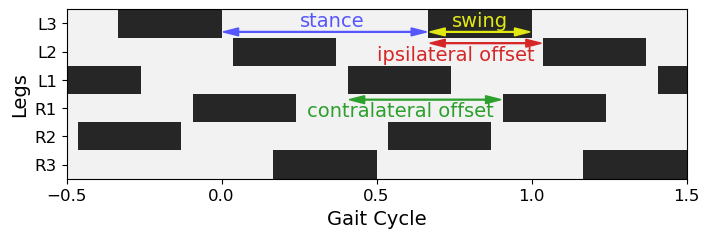

In [3]:
f, ax = plt.subplots(1,1,figsize=(8,2.2))
num_legs = 6
num_cycles = 3 
duty_factor = 2/3 
anterior_offset = 0.37
opposite_offset = 1/2
ax, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax, num_legs, num_cycles, duty_factor, anterior_offset, opposite_offset)

# arrow parameters
arrow_width = 0.03
headwidth = 0.28
headlength = 0.05
arrow_buffer = 0.005

# text label offsets
stance_buffer = 0.082
swing_buffer = 0.09
ipsi_buffer = 0.35
contra_buffer = 0.38

# arrows and text for STANCE
arrow_x = duty_factor / 2
arrow_y = 6.2
dx = duty_factor / 2 - arrow_buffer
stance_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=stance_color)
ax.add_patch(stance_arrow_right)
stance_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=stance_color)
ax.add_patch(stance_arrow_left)

ax.text(arrow_x - stance_buffer, 6.4, 'stance', fontsize=axis_fontsize, color = stance_color)

# arrows and text for SWING
arrow_x = duty_factor + (1 - duty_factor)/2
arrow_y = 6.2
dx = ((1 - duty_factor) / 2) - arrow_buffer
swing_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=swing_color)
ax.add_patch(swing_arrow_right)
swing_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=swing_color)
ax.add_patch(swing_arrow_left)

ax.text(arrow_x - swing_buffer, 6.4, 'swing', fontsize=axis_fontsize, color = swing_color)

# arrows and text for ANTERIOR OFFSET
arrow_x = duty_factor + anterior_offset/2
arrow_y = 5.8
dx = (anterior_offset/2) - arrow_buffer
anterior_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=ipsi_color)
ax.add_patch(anterior_arrow_right)
anterior_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=ipsi_color)
ax.add_patch(anterior_arrow_left)

ax.text(arrow_x - ipsi_buffer, 5.2, 'ipsilateral offset', fontsize=axis_fontsize, color=ipsi_color)

# arrows and text for OPPOSITE OFFSET
arrow_x = 2 * anterior_offset - (1-duty_factor) + opposite_offset/2
arrow_y = 3.8
dx = (opposite_offset/2) - arrow_buffer
oppposite_arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=contra_color)
ax.add_patch(oppposite_arrow_right)
oppposite_arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, 0, head_width=headwidth, head_length=headlength,
                            width=arrow_width, length_includes_head=True, color=contra_color)
ax.add_patch(oppposite_arrow_left)

ax.text(arrow_x - contra_buffer, 3.2, 'contralateral offset', fontsize=axis_fontsize, color=contra_color)

# axis limits and labels
xlow = -0.5
xhigh = 1.5
ax.set_xlim([xlow, xhigh])
ax.set_xticks(np.arange(xlow, xhigh+0.5, 0.5))
ax.xaxis.label.set_size(axis_fontsize)
ax.xaxis.set_tick_params(labelsize=tick_fontsize) # cool
# ax.xaxis.label.set_text('hihihihi') # cool
ax.yaxis.set_tick_params(labelsize=tick_fontsize) # cool
ax.yaxis.label.set_size(axis_fontsize)
plt.show()

### Combined data for all clips

In [4]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
xl_files = sorted(glob.glob('*.xlsx'))
excel_file = gaitFunctions.selectOneFromList(xl_files)

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)


Choose from this list : 
1: exemplaris_2024-01-10.xlsx
2: path_summaries.xlsx

Which ONE would you like? 1

You chose exemplaris_2024-01-10.xlsx



,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,16019.862069,255.118156,NaN,0.667,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,16147.450000,254.255372,NaN,1.030,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,16140.948718,257.286118,NaN,0.879,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# Walking speed vs. step amplitude
### Nirody Figure 2A

n =  3267 strides are shown
ρ = 1.0 p = 0.0


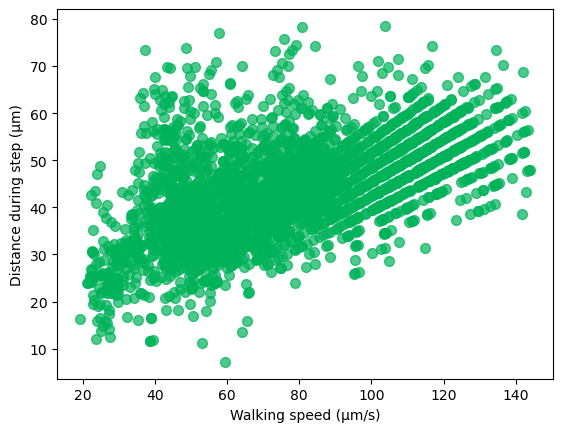

In [5]:
'''

Paper text:
"Step amplitude, defined as the distance between the posterior extreme position (PEP) 
measured at liftoff of a leg at the start of a swing and the anterior extreme position 
(AEP) measured at touchdown of the same leg at the end of swing, increases with forward 
walking speed (Fig. 2A)."

Figure legend:
"Stride length (A) smoothly increases ... with walking speed"

Methods:
"Correlation coefficients between variables were calculated over the entire observed 
walking speed range; we used Spearman ρ to determine correlation due to the nonlinear 
relationships between several of our kinematic variables."

NOTES:  
1. I am only including data when the tardigrades are 'cruising' = not in a stop or a 
turn . . .

2. We define step distance differently = distance traveled by tardigrade during gait cycle.
So this is always going to be correlated to speed. Consider measuring amplitudes . . . 
(lots of re-stepping work)

'''

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L1','L2','L3','R1','R2','R3'])]

speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
distance_during_steps_scaled = step_df['distance_during_step_scaled'].values * 1000
marker_color = '#00b35a'

plt.scatter(speed_during_steps_scaled,distance_during_steps_scaled,c=marker_color,s=50,alpha=0.7)
plt.ylabel('Distance during step (µm)')
plt.xlabel('Walking speed (µm/s)')
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,speed_during_steps_scaled)
print('ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.show()

# Forward walking speed vs. Stride period (gait cycle)
### Nirody Figure 2B

n =  3267 strides are shown
ρ = -0.79 p = 0.0


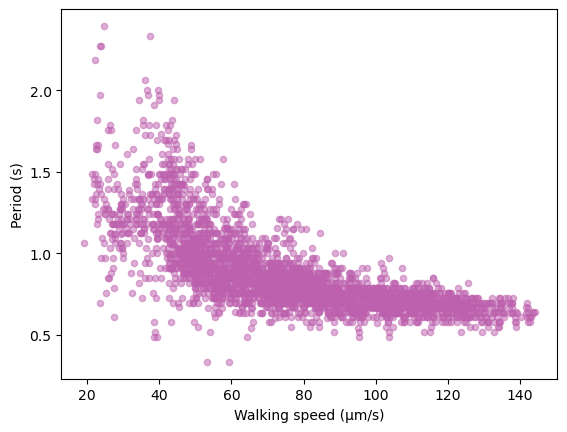

In [6]:
'''
"Stride period decreases with walking speed, plateauing at walking speeds of 
approximately v > 100 μm/s (Fig. 2B)."
'''

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L1','L2','L3','R1','R2','R3'])]

speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
gait_cycles = step_df['gait'].values
marker_color = '#bd61ae'

plt.scatter(speed_during_steps_scaled,gait_cycles,c=marker_color,s=20,alpha=0.5)
plt.ylabel('Period (s)')
plt.xlabel('Walking speed (µm/s)')
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,gait_cycles)
print('ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.show()

# walking speed vs. 1. stance and swing duration and 2. Duty Factor
### Nirody Figures 2C and Figure 3

### Lateral Legs: walking speed vs. 1. stance and swing duration and 2. Duty Factor

n =  3267 strides are shown
Swing: ρ = -0.27 p = 0.0
Stance: ρ = -0.77 p = 0.0
Duty Factor: ρ = -0.51 p = 0.0


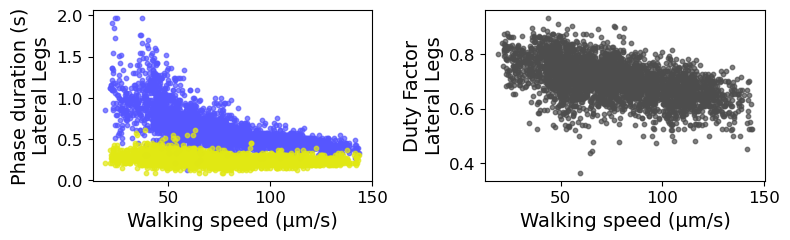

In [7]:
# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L1','L2','L3','R1','R2','R3'])]

# grab data we need
speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
stance_durations = step_df['stance'].values
swing_durations = step_df['swing'].values
duty_factor = step_df['duty'].values

# marker size and alpha
marker_size = 10
marker_alpha = 0.7

f, [ax1,ax2] = plt.subplots(1,2,figsize=(8,2.5))

# Stance and Swing Plot
ax1.scatter(speed_during_steps_scaled,stance_durations,c=stance_color,s=marker_size,alpha=marker_alpha)
ax1.scatter(speed_during_steps_scaled,swing_durations,c=swing_color,s=marker_size,alpha=marker_alpha)
ax1.set_ylabel('Phase duration (s)\nLateral Legs', fontsize = axis_fontsize)
ax1.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,swing_durations)
print('Swing: ρ =', np.round(r,2), 'p =', np.round(p,2))

r,p = stats.spearmanr(speed_during_steps_scaled,stance_durations)
print('Stance: ρ =', np.round(r,2), 'p =', np.round(p,2))

# Duty Factor Plot
ax2.scatter(speed_during_steps_scaled,duty_factor,c=duty_color,s=marker_size,alpha=marker_alpha)
ax2.set_ylabel('Duty Factor\nLateral Legs', fontsize = axis_fontsize)
ax2.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)

r,p = stats.spearmanr(speed_during_steps_scaled,duty_factor)
print('Duty Factor: ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.tight_layout()
plt.show()

### Lateral Legs: walking speed vs. 1. stance and swing duration and 2. Duty Factor

n =  1231 strides are shown
Swing: ρ = -0.3 p = 0.0
Stance: ρ = -0.78 p = 0.0
Duty Factor: ρ = -0.62 p = 0.0


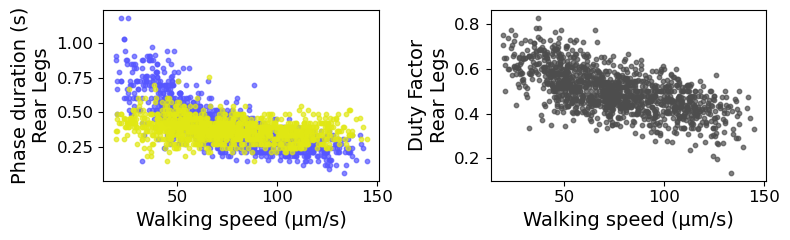

In [8]:
# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# only include lateral legs
step_df = step_df[step_df['legID'].isin(['L4','R4'])]

# grab data we need
speed_during_steps_scaled = step_df['speed_during_step_scaled'].values * 1000
stance_durations = step_df['stance'].values
swing_durations = step_df['swing'].values
duty_factor = step_df['duty'].values

f, [ax1,ax2] = plt.subplots(1,2,figsize=(8,2.5))

# Stance and Swing Plot
ax1.scatter(speed_during_steps_scaled,stance_durations,c=stance_color,s=marker_size,alpha=marker_alpha)
ax1.scatter(speed_during_steps_scaled,swing_durations,c=swing_color,s=marker_size,alpha=marker_alpha)
ax1.set_ylabel('Phase duration (s)\nRear Legs', fontsize = axis_fontsize)
ax1.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
print('n = ', len(speed_during_steps_scaled), 'strides are shown')

r,p = stats.spearmanr(speed_during_steps_scaled,swing_durations)
print('Swing: ρ =', np.round(r,2), 'p =', np.round(p,2))

r,p = stats.spearmanr(speed_during_steps_scaled,stance_durations)
print('Stance: ρ =', np.round(r,2), 'p =', np.round(p,2))

# Duty Factor Plot
ax2.scatter(speed_during_steps_scaled,duty_factor,c=duty_color,s=marker_size,alpha=marker_alpha)
ax2.set_ylabel('Duty Factor\nRear Legs', fontsize = axis_fontsize)
ax2.set_xlabel('Walking speed (µm/s)', fontsize = axis_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)

r,p = stats.spearmanr(speed_during_steps_scaled,duty_factor)
print('Duty Factor: ρ =', np.round(r,2), 'p =', np.round(p,2))

plt.tight_layout()
plt.show()

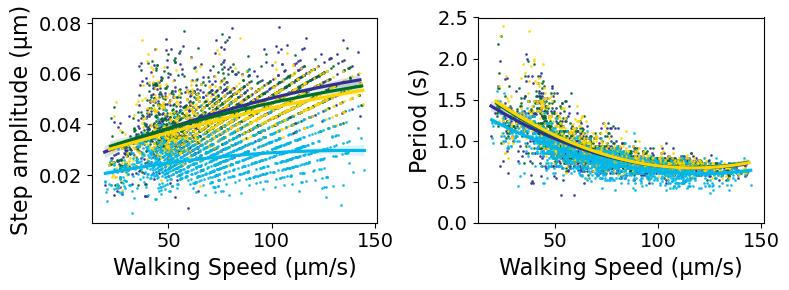

In [19]:
# Speed vs. step amplitude and gait cycle (aka period)
# by LEG PAIR

axis_fontsize = 16
tick_fontsize = 14

leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]
data_desciptions = ['Step amplitude (µm)','Period (s)']#,'Swing duration (s)','Stance duration (s)']
data_cols = ['distance_during_step_scaled','gait']# ,'swing','stance']
speed_col = 'speed_during_step_scaled'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# set up plot
f, axes = plt.subplots(1,2,figsize=(8,3))
ax_handles = axes.reshape(1,2)[0]
for i, d in enumerate(data_desciptions):
    ax = ax_handles[i]
    for j, leg_pair in enumerate(leg_pairs):
        
        # get data for this pair for this datatype
        pair_data = step_df.copy()[step_df['legID'].isin(leg_pair)]
        pair_data[speed_col] = pair_data[speed_col].values * 1000 # convert to µm

        # scatter and regression line ... not so nice b/c cannot figure out fit
#         x_data = pair_data[speed_col].values * 1000
#         y_data = pair_data[data_cols[i]].values 
#         coefficients = np.polyfit(x_data, y_data, 2)
#         fitted_data = np.sort(np.polyval(coefficients, x_data))
#         if d in ['Period (s)','Swing duration (s)','Stance duration (s)']:
#             fitted_data = np.flip(fitted_data)
#         # scatter
#         ax.scatter(x_data,y_data,s=5,c=pair_colors[j],alpha=0.7)
#         # add fit line
#         ax.plot(np.linspace(0, np.max(x_data), len(x_data)),fitted_data,color=pair_colors[j], linewidth=2)
        
        # scatter plot and regression line from seaborn
        xcol = speed_col
        ycol = data_cols[i]
        sns.regplot(data=pair_data, x=xcol, y=ycol, ax=ax, 
                    scatter_kws ={'s':1}, color=pair_colors[j], order=2) # lowess=True
        
    ax.set_ylabel(d, fontsize=axis_fontsize)
    ax.set_xlabel('Walking Speed (µm/s)', fontsize=axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    if d in ['Period (s)','Swing duration (s)','Stance duration (s)']:
        ax.set_ylim([0,2.5])

plt.tight_layout()
plt.show()

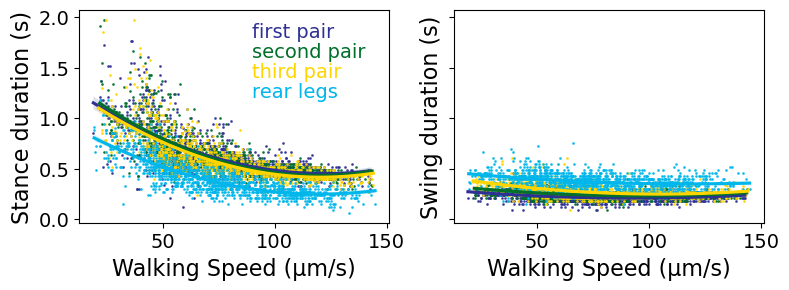

In [24]:
# Speed vs. Stance/Swing and Duty Factor
# by LEG PAIR

axis_fontsize = 16
tick_fontsize = 14

leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]
data_desciptions = ['Stance duration (s)','Swing duration (s)']
data_cols = ['stance', 'swing']
speed_col = 'speed_during_step_scaled'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)

# set up plot
f, axes = plt.subplots(1,2,figsize=(8,3), sharey=True)
[a1,a2] = axes
for i, d in enumerate(data_desciptions):
    ax = axes[i]
    for j, leg_pair in enumerate(leg_pairs):
        
        # get data for this pair for this datatype
        pair_data = step_df.copy()[step_df['legID'].isin(leg_pair)]
        pair_data[speed_col] = pair_data[speed_col].values * 1000 # convert to µm

        # scatter and regression line ... not so nice b/c cannot figure out fit
#         x_data = pair_data[speed_col].values * 1000
#         y_data = pair_data[data_cols[i]].values 
#         coefficients = np.polyfit(x_data, y_data, 2)
#         fitted_data = np.sort(np.polyval(coefficients, x_data))
#         if d in ['Period (s)','Swing duration (s)','Stance duration (s)']:
#             fitted_data = np.flip(fitted_data)
#         # scatter
#         ax.scatter(x_data,y_data,s=5,c=pair_colors[j],alpha=0.7)
#         # add fit line
#         ax.plot(np.linspace(0, np.max(x_data), len(x_data)),fitted_data,color=pair_colors[j], linewidth=2)
        
        # scatter plot and regression line from seaborn
        xcol = speed_col
        ycol = data_cols[i]
        sns.regplot(data=pair_data, x=xcol, y=ycol, ax=ax, 
                    scatter_kws ={'s':1}, color=pair_colors[j], order=2) # lowess=True
        
    ax.set_ylabel(d, fontsize=axis_fontsize)
    ax.set_xlabel('Walking Speed (µm/s)', fontsize=axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# klugey legend
leg_pairs = ['first pair','second pair', 'third pair','rear legs']
ytext = 1.8
yinc = 0.2
xtext = 90
for i, legs in enumerate(leg_pairs):
    a1.text(xtext,ytext,fontsize=tick_fontsize,color=pair_colors[i],s=legs)
    ytext -= yinc

plt.tight_layout()
plt.show()

## offsets: lateral-ipsilateral; lateral-contralateral; rear-contralateral
### lateral-ipsilateral = Nirody Figure 4C "Back-to-front wave of swing initiation"
### lateral-contralateral = Nirody Figure S6B

In [11]:
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# load data from data_file
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
print(step_df.columns)
step_df.head(3)

Index(['legID', 'DownTime', 'UpTime', 'stance', 'swing', 'gait', 'duty',
       'midSwingTime', 'L1_mid_swings', 'R1_mid_swings', 'L2_mid_swings',
       'R2_mid_swings', 'L3_mid_swings', 'R3_mid_swings', 'L4_mid_swings',
       'R4_mid_swings', 'anterior_swing_start', 'contralateral_swing_start',
       'speed_during_step', 'speed_during_step_scaled', 'distance_during_step',
       'distance_during_step_scaled', 'cruising_during_step',
       'average_tardigrade_area', 'average_tardigrade_length',
       'anterior_offsets', 'contralateral_offsets', 'metachronal_lag', 'clip',
       'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,16019.862069,255.118156,NaN,0.667,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,16147.450000,254.255372,NaN,1.030,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,16140.948718,257.286118,NaN,0.879,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


1878 steps for lateral legs (ipsilateral offsets)
1388 steps for lateral legs (contralateral offsets)
540 steps for rear legs


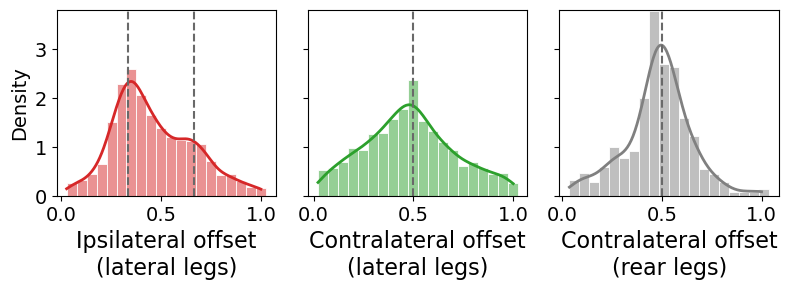

In [12]:
proportions = []
speeds = []
offsets = []
for leg in ipsi_offset_legs:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, ipsi_legs[leg])

# ipsilateral offsets, lateral legs
fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(8,3), sharey=True)
ax1 = sns.histplot(proportions, ax=ax1, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=ipsi_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps for lateral legs (ipsilateral offsets)')
ax1.set_xlabel('Ipsilateral offset\n(lateral legs)', fontsize=axis_fontsize)
ax1.plot([1/3,1/3],[0,4],'--',color='dimgrey')
ax1.plot([2/3,2/3],[0,4],'--',color='dimgrey')

# contralateral offsets, LEFT lateral legs
proportions = []
speeds = []
offsets = []
for leg in left_laterals:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, contra_legs[leg])
ax2 = sns.histplot(proportions, ax=ax2, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=contra_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps for lateral legs (contralateral offsets)')
ax2.set_xlabel('Contralateral offset\n(lateral legs)', fontsize=axis_fontsize)
ax2.set_ylabel('')
ax2.plot([1/2,1/2],[0,4],'--',color='dimgrey')

# contralateral offsets, LEFT rear legs
proportions = []
speeds = []
offsets = []
for leg in ['L4']:
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg, contra_legs[leg])
ax3 = sns.histplot(proportions, ax=ax3, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color='gray', edgecolor='w', visible=True) # can set to False to hide bars
ax3.set_xlabel('Contralateral offset\n(rear legs)', fontsize=axis_fontsize)
ax3.set_ylabel('')
ax3.plot([1/2,1/2],[0,4],'--',color=rear_leg_color)
print(len(proportions), 'steps for rear legs')

# adjust parameters and plot
for ax in [ax1,ax2,ax3]:
    ax.yaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.set_ylim([0,3.8])
    
plt.tight_layout()
plt.show()

### ipsilateral offsets for individual legs

L2 : 465 steps
L3 : 472 steps
R2 : 474 steps
R3 : 467 steps


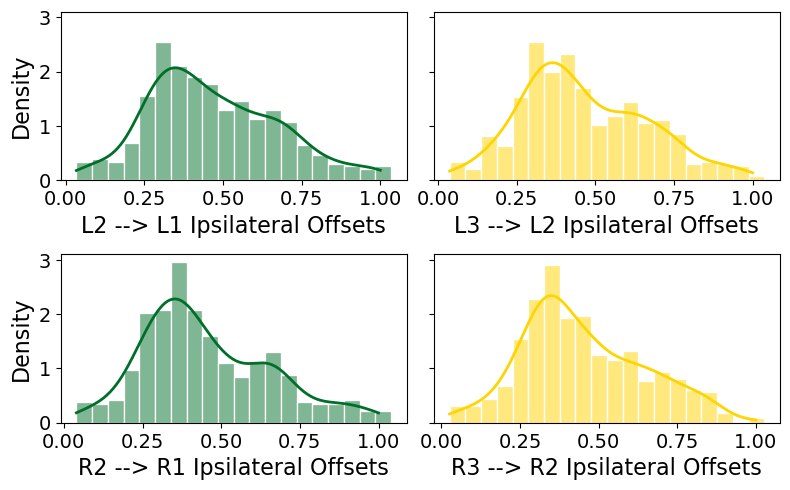

In [13]:
# colors
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color
R3_R2_color =   third_pair_color

f,axes = plt.subplots(2,2,figsize=(8,5), sharey=True)
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

for i, ax in enumerate(axes.flat):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, leg_comps[i][0], leg_comps[i][1])
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    ax.set_xlabel(' --> '.join(leg_comps[i]) + ' Ipsilateral Offsets', fontsize=axis_fontsize)
    
    print(leg_comps[i][0], ':', len(proportions), 'steps')

    
# adjust parameters and plot
for ax in axes.flat:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 


plt.tight_layout()
plt.show()

### Contralateral offsets for individual legs (Nirody S6B inset)

L1 : 471 steps
L2 : 451 steps
L3 : 466 steps


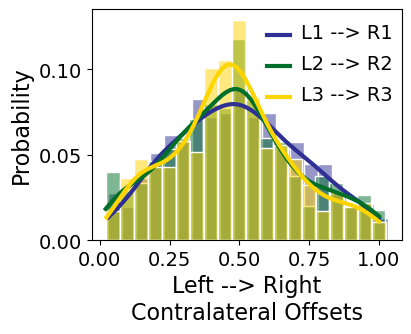

In [29]:
# S6 B inset

f,ax = plt.subplots(1,1,figsize=(4,3))
leg_comps = [['L1','R1'], ['L2','R2'], ['L3','R3']]
plot_cols = [first_pair_color,second_pair_color,third_pair_color]
ypos = 0.12

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, step_df, comp[0], comp[1])
#     H,X1 = np.histogram(proportions, bins = 200, density = True )
#     dx = X1[1] - X1[0]
#     F1 = np.cumsum(H)*dx
#     ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05,
                      stat='probability',line_kws={'linewidth':3}, kde=True,
                      color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    # klugey legend
    plt.plot([0.6,0.68],[ypos,ypos],color=plot_cols[i],linewidth=3)
    plt.text(0.72,ypos-0.002, ' --> '.join(comp),fontsize=tick_fontsize)
    ypos -= 0.018
    
    print(comp[0], ':', len(proportions), 'steps')

ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
ax.set_xlabel('Left --> Right\nContralateral Offsets', fontsize=axis_fontsize)
plt.show()

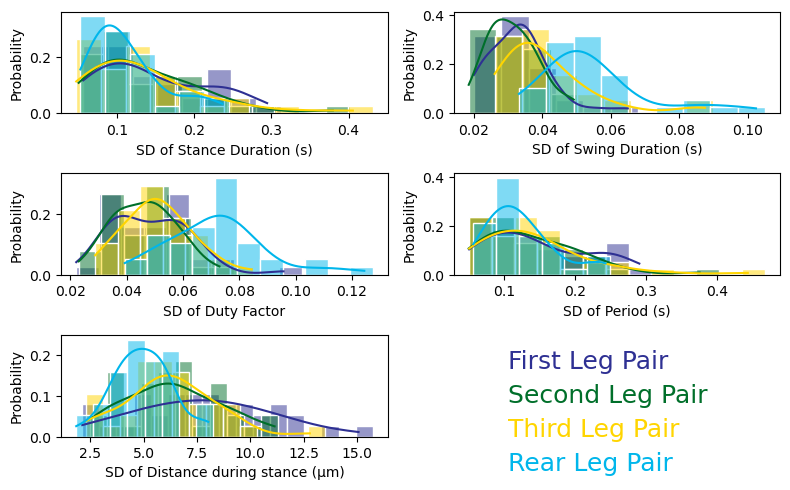

In [28]:
'''
# Variance in step kinematics, Nirody Figure S2

The labels are messed up on their figure ... they use the S1 panel labels, 
and it is not clear what units they are using for the y-axes.<br>

Within-animal standard deviation of kinematic parameters (by leg)<br>
They do step amplitude, period, swing, stance (but not duty factor) 

If I am understanding the figure correctly ... they are taking SD from 
each animal, and making a histogram of those values across multiple animals?

'''

# load gait data from step_timing sheet
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
parameters = ['stance','swing','duty','gait','distance_during_step_scaled']
parameter_labels = ['Stance Duration (s)','Swing Duration (s)','Duty Factor',
                    'Period (s)','Distance during stance (µm)']
parameter_labels = ['SD of ' + x for x in parameter_labels]
binwidths = np.array([ 0.04, 0.01, 0.01, 0.04, 1])
binwidths *= 0.8

# using leg parameter colors from Figure S1 (Nirody uses different colors)
leg_pairs = [['L1','R1'],['L2','R2'],['L3','R3'],['L4','R4']]
leg_pair_labels = ['First Leg Pair','Second Leg Pair','Third Leg Pair','Rear Leg Pair']
leg_pair_colors = [first_pair_color, second_pair_color, third_pair_color, rear_leg_color]

# get unique individuals
individuals = np.sort(np.unique(step_df.uniq_id.values))

# set up figure
f,axes = plt.subplots(3,2,figsize=(8,5))
axes_list = axes.reshape(1,6)[0]

# for each parameter
for i, parameter in enumerate(parameters):
    
    ax = axes_list[i]
    
    # for each leg pair
    for j,leg_pair in enumerate(leg_pairs):

        leg_pair_data = step_df[step_df['legID'].isin(leg_pair)]
        
        # make empty list for std
        std_vals = []

        # for each individual
        for individual in individuals:
            
            individual_data = leg_pair_data[leg_pair_data['uniq_id']==individual][parameter].values
            
            if parameter == 'distance_during_step_scaled':
                individual_data = individual_data * 1000 # convert mm to µm
        
            # calculate std for parameter, and add to empty list
            std_for_parameter = np.nanstd(individual_data)
            std_vals.append(std_for_parameter)

        # done collecting data for parameter and leg pair ... convert list to numpy array and add to plot
        std_vals = np.array(std_vals)
        
        ax = sns.histplot(std_vals, ax=ax, binwidth=binwidths[i], kde=True, stat='probability',
                 color=leg_pair_colors[j],edgecolor='w',visible=True) # can set to false to hide bars
        
        ax.set_xlabel(parameter_labels[i])
        
# last axes = labels
axes_list[5].set_axis_off()
textpos_x = 0.5
textpos_maxy = 0.8 
textpos_yincrement = 0.1
for i,leg_pair in enumerate(leg_pairs):
    axes_list[5].text(textpos_x, textpos_maxy-(i*textpos_yincrement),
                     leg_pair_labels[i], color=leg_pair_colors[i],fontsize=18)

axes_list[5].set_xlim([0.4,1])
axes_list[5].set_ylim([0.6,0.9])
plt.tight_layout()

plt.show()

# Data table for step kinematics
### Nirody supplemental data table S2

WORKING should also report seconds analyzed and steps analyzed for each tardigrade

Total number of gait cycles analyzed:  4498
Number of individuals analyzed:   38


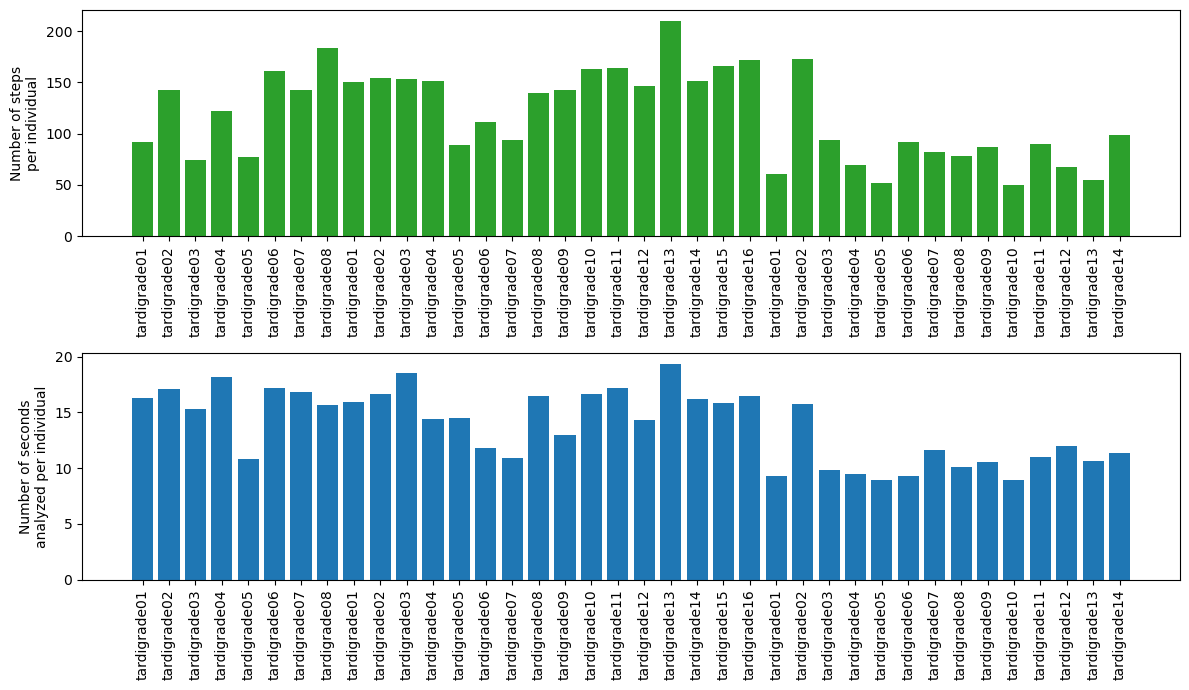

In [15]:
# report number of steps analyzed per individual
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
print('Total number of gait cycles analyzed: ', len(step_df))
f,(a1,a2) = plt.subplots(2,1,figsize=(12,7))
individuals = np.sort(np.unique(step_df['uniq_id'].values))
print('Number of individuals analyzed:  ', len(individuals))
for i, individual in enumerate(individuals):
    steps_for_individual = len(step_df[step_df['uniq_id']==individual])
    a1.bar(i, steps_for_individual, color = 'tab:green')
a1.set_ylabel('Number of steps\nper individual')
a1.set_xticks(np.arange(0,len(individuals)))
a1.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)

# report total time collecting step data per individual
# load data from gait_styles sheet
fps = 33
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
secs_analyzed = gait_df['Number of frames'].values / fps
for i, individual in enumerate(individuals):
    a2.bar(i, secs_analyzed[i], color = 'tab:blue')
a2.set_ylabel('Number of seconds\nanalyzed per individual')
a2.set_xticks(np.arange(0,len(individuals)))
a2.set_xticklabels([x.split('_')[2] for x in individuals], rotation=90)
plt.tight_layout()
plt.show()

In [30]:
''' 
NIRODY Table S2 Values:
'Number of animals': [23,20],
'Body length (μm)':['338.12 ± 45.04','364.53 ± 44.09'],
'Walking speed (μm/s)':['160.50 ± 57.79','91.0 ± 32.0'],
'Step length (μm)': ['90.52 ± 23.70','82.07 ± 19.74'],
'Period (s)': ['0.82 ± 0.24','1.27 ± 0.41'],
'Stance duration (s)': ['0.57 ± 0.21','0.97 ± 0.37'],
'Swing duration (s)': ['0.25 ± 0.08','0.30 ± 0.09'],
'Duty Factor (%)': ['0.68 ± 0.08','0.75 ± 0.07']
'''

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

row_names = ['Number of animals',
             'Body length (μm)',
             'Walking speed (μm/s)',
             'Speed (length/s)',
             'Step length (μm)',
             'Period (s)',
             'Stance duration (s)',
             'Swing duraction (s)',
             'Duty Factor (%)',
            ]

nirody_50pa = ['23','338.12 ± 45.04','160.50 ± 57.79',str(np.round(160.5/338.12,2)),'90.52 ± 23.70',
              '0.82 ± 0.24','0.57 ± 0.21','0.25 ± 0.08','0.68 ± 0.08']

nirody_10pa = ['20','364.53 ± 44.09','91.0 ± 32.0',str(np.round(91/364.53,2)),'82.07 ± 19.74',
              '1.27 ± 0.41','0.97 ± 0.37','0.30 ± 0.09','0.75 ± 0.07']

colname = 'Woodslab'

# load the path summaries data into a dataframe (this has size and speed data)
path_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
print(path_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')


## Compare to Nirody values

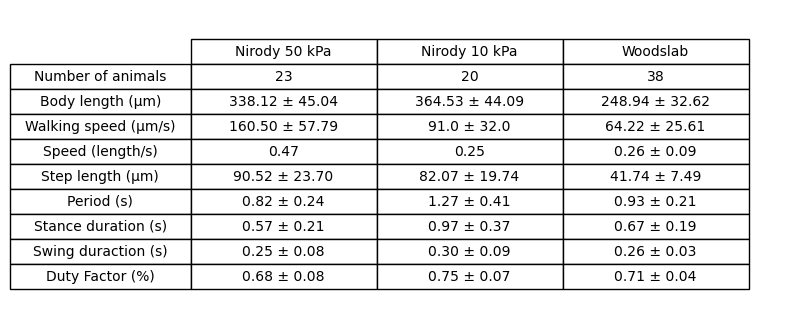

In [27]:
number_animals = str(len(path_df.individual.values))
body_length = meanstdstr(path_df['Body Length (mm)'].values * 1000)
speed_scaled = meanstdstr(path_df['Speed (mm/sec)'].values * 1000) # sec or sec cruising
speed_normalized = meanstdstr(path_df['Speed (body lengths / sec)'].values) # sec or sec cruising
# speed_scaled = meanstdstr(path_df['Speed (mm/sec cruising)'].values * 1000) # sec or sec cruising
# speed_normalized = meanstdstr(path_df['Speed (body lengths / sec cruising)'].values) # sec or sec cruising

# load the step_summaries data into a dataframe (this has step kinematics data)
step_summaries_df = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
step_length = meanstdstr(step_summaries_df['mm per step (lateral legs)'].values * 1000)
period = meanstdstr(step_summaries_df['Gait cycle (lateral legs)'].values)
stance_duration = meanstdstr(step_summaries_df['Stance duration (lateral legs)'].values)
swing_duration = meanstdstr(step_summaries_df['Swing duration (lateral legs)'].values)
duty_factor = meanstdstr(step_summaries_df['Duty factor (lateral legs)'].values)

col_data = [number_animals, body_length, speed_scaled, speed_normalized, step_length,
           period, stance_duration, swing_duration, duty_factor]

table_vals = np.column_stack([nirody_50pa,nirody_10pa,col_data])
col_labels = ['Nirody 50 kPa','Nirody 10 kPa', colname]
row_labels = row_names
row_colors = ['white'] * len(row_labels)
col_colors = ['white'] * len(col_labels)

plt.figure(figsize=(8,4))
ax = plt.gca()

my_table = plt.table(cellText=table_vals,
                     colWidths=[0.3] * len(col_labels),
                     rowLabels=row_labels,
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
#                      cellColours=cell_colors,
                     rowColours=row_colors,
                     colColours=col_colors,
#                      edges='horizontal',
                     loc='center')
my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
plt.show()

In [36]:
print(step_summaries_df.columns)
# WORKING need to add seconds analyzed and steps analyzed ... add to analyzeSteps!
# print(len(columns_to_analyze))

Index(['Identifier', 'treatment', 'individual',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)', 'bodylength per step (rear legs)',
       'Metachronal lag (lateral legs)',
       'Metachronal lag (normalized, lateral legs)',
       'Metachronal lag Left-Right Ratio',
       'Anterior swing offsets (lateral legs)',
       'Anterior swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (lateral legs)',
       'Opposite swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (rear legs)',
       'Opposite swing offsets (normalized, rear legs)'],
      dtype='object')


# Podograms
### Nirody Figure 1C

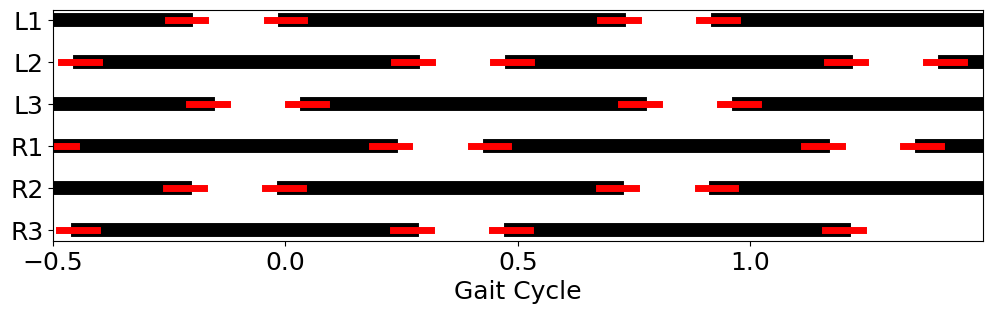

In [34]:
'''
red bars show std of stance duration and swing duration

The code below will make a podogram from the step_summaries sheet,
which contains average data for all lateral legs (and for rear legs).
''' 
plot_order = ['R3','R2','R1','L3','L2','L1']

# load the step_summaries data into a dataframe
step_summaries_df = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
stances = step_summaries_df['Stance duration (lateral legs)'].values / step_summaries_df['Gait cycle (lateral legs)'].values
swings = step_summaries_df['Swing duration (lateral legs)'].values / step_summaries_df['Gait cycle (lateral legs)'].values
gait_cycles = step_summaries_df['Gait cycle (lateral legs)'].values
ipsilateral_offset_mean = np.mean(step_summaries_df['Anterior swing offsets (normalized, lateral legs)'].values)
contralateral_offset_mean = np.mean(step_summaries_df['Opposite swing offsets (normalized, lateral legs)'].values)

stances_mean = np.mean(stances)
stances_std = np.std(stances)
swings_mean = np.mean(swings)
swings_std = np.std(swings)
gait_cycle_mean = np.mean(gait_cycles)

# get leg offsets for plot
leg_offsets = {}
for i, leg in enumerate(['R3','R2','R1']):
    leg_offsets[leg] = i * ipsilateral_offset_mean
for leg in ['R3','R2','R1']:
    contralateral_leg = 'L' + leg[1:]
    leg_offsets[contralateral_leg] = leg_offsets[leg] + contralateral_offset_mean
start_leg = 'L1'
plot_leg_offsets = {}
for k,v in leg_offsets.items():
    plot_leg_offsets[k] = leg_offsets[k] - leg_offsets[start_leg]

# set up plot
f,a = plt.subplots(1, figsize = (12,3))

# it looks like Nirody is plotting data for each leg separately (e.g. the error bars are different)
# should we do that? Or get data for each leg and plot independently?
# if we get data for each leg, how to deal with variation in step number between individual animals?
for i,leg in enumerate(plot_order):
    first_start = plot_leg_offsets[leg]
    for j in [-1,0,1,2]:
        start_stance = first_start + (j * gait_cycle_mean)
        end_stance = start_stance + stances_mean
        # plot stances
        plt.plot([start_stance,end_stance],[i,i],'k',linewidth=10)
        # plot stance errors
        plt.plot([end_stance-stances_std,end_stance+stances_std],[i,i],'r',linewidth=5)
        # plot swing_errors
        plt.plot([start_stance-swings_std,start_stance+swings_std],[i,i],'r',linewidth=5)

xlims = [-0.5,1.5]     
a.set_xlim(xlims)  
a.set_xlabel('Gait Cycle',fontsize=18)
a.set_xticks(np.arange(xlims[0],xlims[1],0.5))
a.set_yticks(np.arange(0,len(plot_order)))
a.set_yticklabels(plot_order)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

ipsilateral offset mean:   0.42
contralateral offset mean: 0.47


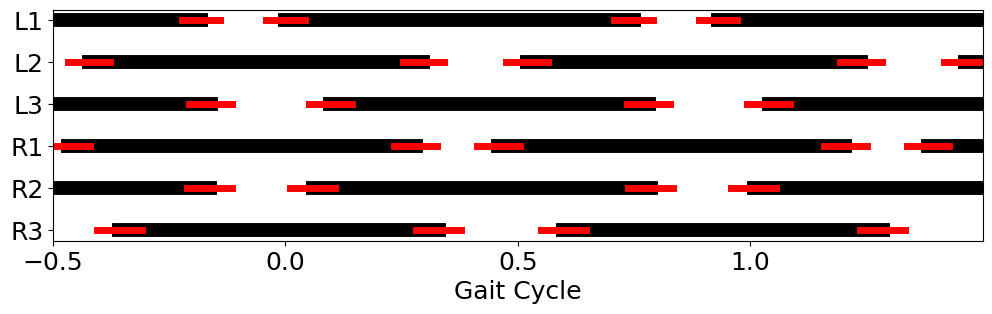

In [35]:
'''
Nirody figure 1C ... podogram 
red bars show std of stance duration and swing duration

The code below will make a podogram from the step_timing sheet,
which contains data for each step for each leg for each individual

We will calculate average stance, swing, gait cycle values for each leg 
of each individual animal, and then plot averages of these
''' 
plot_order = ['R3','R2','R1','L3','L2','L1']

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
# print(step_df.head(3)) # testing

# for each individual, for each leg, get:
# number of steps, stance durations, swing durations, 
# store in dictionary: step_data[leg][parameter] = [mean values for each individual]
step_data = {}
individuals = sorted(np.unique(step_df['uniq_id'].values))
parameters = ['stance','swing','gait','duty','anterior_offsets','contralateral_offsets']

# set up empty dictionary
for leg in plot_order:
    step_data[leg] = {}
    step_data[leg]['number_of_steps'] = []
    for parameter in parameters:
        step_data[leg][parameter] = []
total_steps = {}  # key = individual ID, val = total steps in analysis
total_steps_overall = 0
        
# get the data for each individual and each leg, and add average value to dictionary
for individual in individuals:
    
    total_steps[individual] = 0
    
    # get slice of data for this individual
    individual_df = step_df[step_df['uniq_id'] == individual]
    for leg in plot_order:
        # get slice of data for this leg
        leg_df = individual_df[individual_df['legID']==leg]
        for parameter in parameters:

            # get data for this parameter for this leg for this individual
            parameter_data = leg_df[parameter].values

            # get mean value of this data ... 
            # need some care - some data contains nan
            # and some paramaters will have no data!
            if len(parameter_data) > 0 and np.any(~np.isnan(parameter_data)):
                mean_parameter_data = np.nanmean(parameter_data)
            else:
                mean_parameter_data = np.nan
            
            # append this mean value to the dictionary
            step_data[leg][parameter].append(mean_parameter_data)
            
            # keep track of number of steps per individual and per leg
            if parameter == 'stance':
                # count number of steps
                number_of_steps = len(parameter_data)
                step_data[leg]['number_of_steps'].append(number_of_steps)
                total_steps[individual] += number_of_steps
                total_steps_overall += number_of_steps

# To find inter-leg timing, we will need overall value for
# anterior offsets and contralateral offsets
all_anterior_offsets = []
all_contralateral_offsets = []
for individual in individuals:
    for leg in plot_order:
        all_anterior_offsets.extend(step_data[leg]['anterior_offsets'])
        all_contralateral_offsets.extend(step_data[leg]['contralateral_offsets'])
ipsilateral_offset_mean = np.nanmean(all_anterior_offsets)
contralateral_offset_mean = np.nanmean(all_contralateral_offsets)
print('ipsilateral offset mean:  ', np.round(ipsilateral_offset_mean,2))
print('contralateral offset mean:', np.round(contralateral_offset_mean,2))

# get leg offsets for plot
leg_offsets = {}
for i, leg in enumerate(['R3','R2','R1']):
    leg_offsets[leg] = i * ipsilateral_offset_mean
for leg in ['R3','R2','R1']:
    contralateral_leg = 'L' + leg[1:]
    leg_offsets[contralateral_leg] = leg_offsets[leg] + contralateral_offset_mean
start_leg = 'L1'
plot_leg_offsets = {}
for k,v in leg_offsets.items():
    plot_leg_offsets[k] = leg_offsets[k] - leg_offsets[start_leg]

# set up plot
f,a = plt.subplots(1, figsize = (12,3))

# ready to plot ... 
for i,leg in enumerate(plot_order):
    first_start = plot_leg_offsets[leg]
    gait_cycle_mean = np.nanmean(step_data[leg]['gait'])
    stances = np.array(step_data[leg]['stance']) / np.array(step_data[leg]['gait'])
    stances_mean = np.nanmean(stances)
    stances_std = np.nanstd(stances)
    swings = np.array(step_data[leg]['swing']) / np.array(step_data[leg]['gait'])
    swings_std = np.nanstd(swings)
    
    for j in [-1,0,1,2]:
        start_stance = first_start + (j * gait_cycle_mean)
        end_stance = start_stance + stances_mean
        # plot stances
        plt.plot([start_stance,end_stance],[i,i],'k',linewidth=10)
        # plot stance errors
        plt.plot([end_stance-stances_std,end_stance+stances_std],[i,i],'r',linewidth=5)
        # plot swing_errors
        plt.plot([start_stance-swings_std,start_stance+swings_std],[i,i],'r',linewidth=5)

xlims = [-0.5,1.5]     
a.set_xlim(xlims)  
a.set_xlabel('Gait Cycle',fontsize=18)
a.set_xticks(np.arange(xlims[0],xlims[1],0.5))
a.set_yticks(np.arange(0,len(plot_order)))
a.set_yticklabels(plot_order)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()